In [1]:
import pandas as pa
import numpy as np
import matplotlib as plt
%matplotlib inline
import torch



In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Frist Method: Working out the probablitys

In [4]:
N = torch.zeros((27, 27), dtype=torch.int32)

We want to be working with numbers rather then characters and there is a clear canonical map between them. 
$$
\{\text{ . , a,b, c} \dots \text{,z}\} \longleftrightarrow \{1,2, \dots,27\}
$$

we should note that we have assumed hre that every letter in the alphabet comes up at least once in are data, which we have checked to be true.

In [5]:
chars = sorted(list(set(''.join(words))))                                               #NOTE: Set doesnt allow for repatition
stoi = {s:i+1 for i,s in enumerate(chars)}  
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

len(chars)

26

In [6]:
for w in words:
  chs = ['.'] + list(w) + ['.']                                                          #NOTE: that we dont need to distingues between the start and the end here
  for ch1, ch2 in zip(chs, chs[1:]):                                                     #NOTE: nice trick to know, works since in zip ends when either is out of index
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1
    

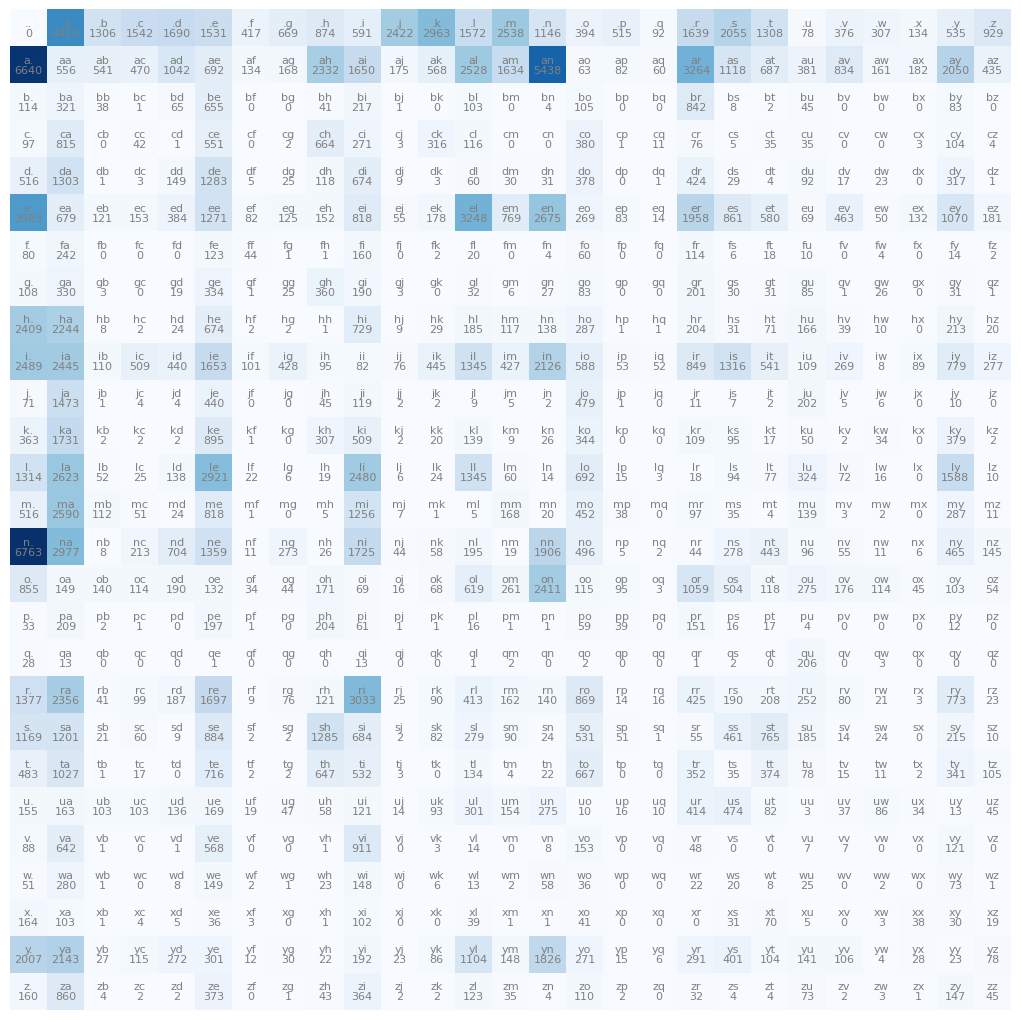

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,13))
plt.imshow(N, cmap='Blues')                                                                  
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray', fontsize=8)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray', fontsize=8)
plt.axis('off');

Here we chave formated the data, and our choice of not distingueting between the start and the end gets rid of row and a colunm that would not have any useful data since,

Is < s > was the start and < e > was the end, we would have a row of pairs: < e >a, < e >b, ..., < e >< e > all of which would be 0, Similarly we would have a column of pairs: a< s >, ... , < s >< s >, < e >< s > which would all be zero. (the only assume on the data is that there is no name of length 0: which there is not).

In [8]:
P = (N+1).float() # smoothing                                                       #NOTE: we as one as to make it so no value is 0, since then that would give a 0 possibly for some plausable names
P /= P.sum(1, keepdims=True)                                                        #NOTE: we keep the dimension as how Boradcasting semantics works in pytorch

Two tensors are 'Broadcastable' if the following rules hold: 

 1. Each tensor has at least one dimension
 2. when irerating oveer the dimension sizes starting at the trialing dimension (the right), the dimnesion sizes must either be equal, one of them is 1, or one of them doesnt exist.

 So in our case:

 we have dim(P) = $(27,27)$, and  dim(P.sum(1, keepdims=True)) = $(27,1)$. Therefore,
$$
 (27,27) \\
 (27, 1)
$$
 Clealy follows the rules to be broadcastable, so when doing this operation we have that P.sum(1, keepdims=True) is a column vecotor wiht each row consitening of the sum of that row, the broadcasting will copy this column so that it is (27,27) then apply the division term by term. 


$$
P = \begin{pmatrix}p_{1,1} & \dots & p_{1,27} \\ \vdots & \ddots & \vdots  \\ p_{27,1}  & \dots  & p_{27,27}\end{pmatrix},\ \ Q= \begin{pmatrix}\sum_{i=0}^{26}\limits p_{1,i} \\ \vdots \\ \sum_{i=0}^{26}\limits p_{27,i}\end{pmatrix}
$$
Where $Q$ = P.sum(1, keepdims=True), which by extending broadcasting becomes,
$$
\begin{pmatrix}Q  &  \dots &  Q \end{pmatrix}
$$  
which is $(27,27)$.

 However if we dont keep the dimension: 
 again we have have dim(P) = $(27,27)$ but dim(P.sum(1)) = $(27)$. Therefore we have,
$$
 (27,27)\\
 (27)
 $$
 since we 'work from' the right, it goes to 
 $$
 (27,27) \\
    (27)
 $$   
which is broactable also, but instead of repeading the columns hoziontally here it acts as a row and is stracked vertically. which is not what we want.

**NOTE when it is the first dimension think row, when its the second think column**

Lets see how the model works by grabing some names fomr it.

In [9]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


We anitionally notince that it doesnt look that great, with 2 of them just being a single letter. However it is worth noteing what this would look like without the probablitltys from out model:

In [10]:
g = torch.Generator().manual_seed(2147483647)           #i think g might have to be in the cell 
for i in range(10):
    out = []
    ix = 0 
    while True:
        p =torch.ones(27)/27.0
        ix = torch.multinomial(p,num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        
    print(''.join(out))

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.


As we can see this is a great inprovement from the baseline. 

Let Evaluate how this module does.
To do this we want a 'loss' function, here we are choicing the negative log likelihood, since:

maximize likelihood of the data w.r.t. model parameters (statistical modeling)

is equivalent to maximizing the log likelihood (because log is monotonic)

is equivalent to minimizing the negative log likelihood

is equivalent to minimizing the average negative log likelihood


In [11]:
log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## Method two: we are going to make a very simple one layer 'network' to train a set of bigrams (x,y)


In [12]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [13]:
import torch.nn.functional as F

# gradient descent

for k in range(150):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
  logits = xenc @ W                             # predict log-counts
  counts = logits.exp()                         # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()                #NOTE: the second par of this sum is doing the same job as the +1 in
                                                                                        #      the above method when we where smoothing the data, here we want
                                                                                        #      all the values to be close to 0, which is what this constraint does
                                                                                        #      it can be thought is intuativlty as like the 'gravity' of the model. 
                                                                                        #      the 0.01 is the factor that controls how much of an effect this has,
                                                                                        #      and is call the Regularisation loss.

  print(loss.item())
  
  # backward pass
  W.grad = None                                 # set to zero the gradient
  loss.backward()
  
  # update weights
  W.data += -50 * W.grad

3.7686190605163574
3.378786325454712
3.1610782146453857
3.027181386947632
2.9344804286956787
2.8672285079956055
2.81665301322937
2.777146100997925
2.745253801345825
2.7188305854797363
2.696505546569824
2.6773722171783447
2.6608059406280518
2.6463515758514404
2.6336653232574463
2.622471570968628
2.6125476360321045
2.6037065982818604
2.595794439315796
2.5886807441711426
2.5822560787200928
2.5764291286468506
2.5711233615875244
2.566272735595703
2.5618226528167725
2.5577261447906494
2.5539441108703613
2.550442695617676
2.547192335128784
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527860164642334
2.526063919067383
2.5243709087371826
2.522773265838623
2.521263837814331
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990972518921
2.5148372650146484
2.5137407779693604
2.51269793510437
2.511704921722412
2.5107581615448
2.509855031967163
2.5089921951293945
2.5081686973571777
2.507380485534668
2.5

We see that we get a very similar value to are previous method, which is what are goal was in this case, since we wouldnt expect the module to be able to do much better then it, yet. In a sense we have just created a different way of getting that P matrix, (now are W has converged to almost P).

In [14]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    # p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


We now that this is very simpliar to what we got with the previous method. However there difference there is a lot more we can do to build ontop of this method.

Since there is a lot of information in a short amount of code, more detail on smalled cases bellow.

Let look at the first word, to begin 

In [15]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [16]:
xs

tensor([ 0,  5, 13, 13,  1])

In [17]:
ys

tensor([ 5, 13, 13,  1,  0])

Here we can see that we have what we would expect, ys is just xs 'shifted one'. 

Now we run into a problem here, we have integers and that is the only way we can corespond to our dictionary of chars, but we dont want to feed int into a network since they will not say as interges, so intead you use a techinque called **oneheart encoding** which sends a value n and makes a vector of size (number of possible chars) and makes the vector 0 par the element of index n.
This is easily understood in an example:

In [18]:
xenc = F.one_hot(xs, num_classes=27)
xenc

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

If we compare this to xs it is clear what it is doing.

We can view this in the same way with imshow() as before, although since it is not really important we will not be formatting.

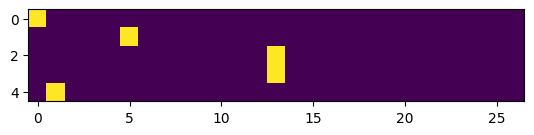

In [19]:
plt.imshow(xenc)

Now here we have a small problem with a easy fix, what is the dtype of xenc:

In [20]:
xenc.dtype

torch.int64

But as stated earlier we dont want to input ints to are 'network', normally we would be able to spesify the dtype when calling the one_hot function (..., dtype=float32). However this is not possible sowe can jsut cast it after.

In [21]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.dtype

torch.float32

Since we have no bieses in are 'network', each later is just the multplication of the input vector dot product the wieght, but this is the same as matrix multiplication by definition. 

In [22]:
#initcial weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)                #NOTE: this is  a normal distribution
logits = xenc @ W # log-count                                            #NOTE: this is a matrix operator in pytorch           #(5,27) @ (27,27) -> (5,27)
                                                                         #NOTE: this is telling us the fireing rate of those neurals on those 5 exmaples
(xenc @ W )[3,13]                                                        #NOTE: the firing rate of the 13th neural looking at the 3rd input

tensor(0.0379, grad_fn=<SelectBackward0>)

In [23]:
counts = logits.exp()                                                   # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)                           # probabilities for next character

Lets consider the loss over this example.

In [24]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item()                                                       # input character index
  y = ys[i].item()                                                       # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('======')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
       grad_fn=<SelectBackward0>)
label (actual next character):

As we can see above we just did the same but for the whole data set.